In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import re
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import OneHotEncoder
from multiprocessing import Pool, cpu_count

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
archive = zipfile.ZipFile('dataset.zip', 'r')
[z for z in [re.findall('filename=\'(.+?)\'',y)[0] for y in [str(x) for x in archive.filelist]] if z.find('MAC')<0]

['clients.csv', 'editors.csv', 'tickets.csv', 'tasks.csv']

In [3]:
clients = pd.read_csv(BytesIO(archive.read('clients.csv')))
editors = pd.read_csv(BytesIO(archive.read('editors.csv')))
tasks = pd.read_csv(BytesIO(archive.read('tasks.csv')))
tickets = pd.read_csv(BytesIO(archive.read('tickets.csv')))

In [4]:
# merge tables
tickets_clients = pd.merge(left=tickets, right=clients, how='left', left_on='client_id.1', right_on='id')
tasks_tickets_clients = pd.merge(left=tasks, right=tickets_clients, how='left', left_on='ticket_id', right_on='id_x')
domains = 'travel,fintech,ecommerce,sports,gamming,health_care'.split(',')

# Summary
- Tickets are broken into tasks, that are assigned to editors.
- Tasks have a language pair, a certain number of words, and a specific domain.
- Editors' skills are broken down per domain. --> *language_pair is missing.*
- Task assignment problem:
    - task quality is dependent on the editors skill, so editors with better skill at the task's domain should be assigned to it.
    - assignment should be balanced so that all the editors can eat.
    
**Approach**
- assign language_pairs to editors, break the problem per language (language_pairs proportion is similar over the domains).
- optimize task assignment with constrains on quality (editor's domain skill) and assignment balance (avoid concentration).

## There is an imbalance at task domain

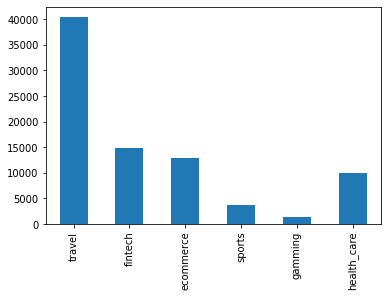

In [5]:
p = tasks_tickets_clients['domain'].value_counts()[domains].plot(kind='bar')

## Also at editors skills
Travel skills are the most lacking while most tasks are in the travel domain

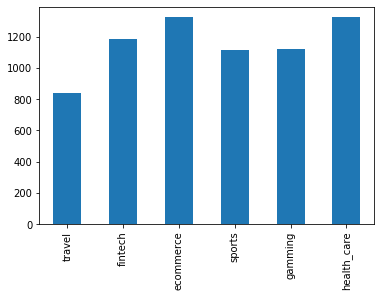

In [6]:
p = editors[domains].sum(axis=0).plot(kind='bar')

## language_pair proportion is similar over the domains

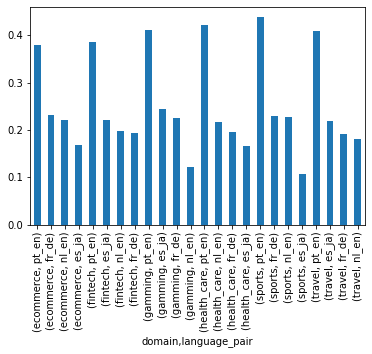

In [7]:
p = tasks_tickets_clients.groupby('domain')['language_pair'].value_counts(normalize=True).plot(kind='bar')

In [8]:
# editors do not have language pair -- assign randomly with the same distribution as in tasks
editors.drop(editors.columns[0], axis=1, inplace=True)
editors.reset_index(inplace=True)
editors_r = editors.sample(frac=1, random_state=42)
editors_r.reset_index(drop=True, inplace=True)
editors_r['language_pair'] = tasks_tickets_clients.language_pair.sample(n=editors.shape[0], random_state=42).values

In [9]:
# break the problem for 1 language pair = nl_en
# nl_en
nl_en_tasks = tasks_tickets_clients.loc[tasks_tickets_clients['language_pair'] == 'nl_en']
# create a zero-one matrix of domain per tasks
enc = OneHotEncoder()
nl_en_jde = enc.fit_transform(nl_en_tasks['domain'][:, None]).toarray()
# fix col order to ['travel', 'fintech', 'ecommerce', 'sports', 'gamming', 'health_care']
nl_en_jdedf = pd.DataFrame(nl_en_jde, columns=enc.categories_)
nl_en_job_domain = nl_en_jdedf[domains].values
# array of tasks' number of words 
nl_en_job_words = nl_en_tasks['number_words_x'].values
# editors
nl_en_editors = editors_r[editors_r['language_pair'] == 'nl_en']
# matrix of editors' domain skill
nl_en_editor_domain_skill = nl_en_editors[domains].values
# defining task quality per editor's skill. Weighted Domain Skill = average skill * domain skill
    # matrix of editor quality per domain
nl_en_editor_domain_quality = pd.DataFrame(nl_en_editor_domain_skill).apply(lambda x: np.mean(x / 5) * (x / 5),
                                                                            axis=1).values

# Optimization with a Genetic Algorithm (GA)
To optimize task assignment, jobs will be assigned to editors in a zero-one matrix, with editors on rows and jobs on columns

In [10]:
# for instance
pd.DataFrame([[1,0,0],[0,1,0],[0,0,1]],columns='task_1,task_2,task_3'.split(','),\
             index='editor_1,editor_2,editor_3'.split(','))

,task_1,task_2,task_3
editor_1,1,0,0
editor_2,0,1,0
editor_3,0,0,1


The initial order will be randomly generated, preventing the formation of zero-only rows (where an editor would have no tasks).
The sequence of the GA will be the following:
- a random population of chromosomes is generated;
- the population is ranked by a fitness function;
- the next generation is selected:
    - a group of the population is selected to pass to the next generation (elite);
    - another group is selected for breeding, by chance with proportion to fitness;
    - inverted exchange crossover is performed on chromosomes to generate the offspring;
    - the whole population is submitted to mutation at a mutation rate - mutation is swapping of adjacent columns.
- this is repeated for N generations.

The fitness function will be based on the total quality of the tasks (sum) multiplied by a balance factor. This balance factor will take into consideration:
- the distance between the maximum and minimum number of tasks per agent;
- the skewness and the kurtosis of the task distribution. 
- the factors are created so to minimize skewness in both directions and 
minimize overall kurtosis, which will force a uniform distribution.
- a penalty factor can be used to increase or decrease the balancing factor's effect.

## runnning the solution

In [11]:
from genetic import gen_pop_mp, genetic_algorithm_mp, gen_pop, genetic_algorithm

In [15]:
# # open mp pool
# num_processors = cpu_count()  
# pool = Pool(processes=num_processors)
# print(f'using {num_processors} processors')
# # testing on a 4 cpu machine shows the overhead is too big for mp to be worth it - cython should be better
# # also, profiling needs to be done to identify bottlenecks

# matrix_shape = (89, 16290)
shape = (nl_en_editors.shape[0], nl_en_tasks.shape[0])

# generate initial population
pop_size = 50
print('generating population')
# ini_pop = gen_pop_mp(pop_size, shape, pool)
ini_pop = gen_pop(pop_size, shape, 42)

# additional parameters
elite_size = 8
mut_rate = 0.01
balance_penalty = 50  # 1 = no balance constrain
generations = 100
print('running ga')
# pop_ranks, best_ind = genetic_algorithm_mp(ini_pop, elite_size, mut_rate, balance_penalty,
#                                            generations, nl_en_job_domain, nl_en_editor_domain_quality, pool)
pop_ranks, best_ind = genetic_algorithm(ini_pop, elite_size, mut_rate, balance_penalty,
                                           generations, nl_en_job_domain, nl_en_editor_domain_quality)

# pool.close()
# pool.join()

generating population
running ga
    index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
40     40  5236.558204         4690.0        0.028178      0.021277   0.105594  -0.961413    1
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5236.558204         4690.0        0.028178      0.021277   0.105594  -0.961413    2
    index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
29     29  5238.318325    4689.666667        0.028282      0.021277    0.10225  -0.961278    3
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5238.318325    4689.666667        0.028282      0.021277    0.10225  -0.961278    4
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5238.318325    4689.666667        0.028282      0.021277    0.10225  -0.961278    5
   index      fitness  

   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5363.307993    4774.246667         0.02974      0.020833   0.000362  -0.856104   45
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5363.307993    4774.246667         0.02974      0.020833   0.000362  -0.856104   46
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5363.307993    4774.246667         0.02974      0.020833   0.000362  -0.856104   47
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5363.307993    4774.246667         0.02974      0.020833   0.000362  -0.856104   48
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5363.307993    4774.246667         0.02974      0.020833   0.000362  -0.856104   49
   index      fitness  total_quality  balance_factor  range_

   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5487.624848         4765.7        0.036056      0.023256   0.040337  -1.231133   89
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5487.624848         4765.7        0.036056      0.023256   0.040337  -1.231133   90
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5487.624848         4765.7        0.036056      0.023256   0.040337  -1.231133   91
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5487.624848         4765.7        0.036056      0.023256   0.040337  -1.231133   92
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5487.624848         4765.7        0.036056      0.023256   0.040337  -1.231133   93
   index      fitness  total_quality  balance_factor  range_

In [16]:
# this concatenates data from all the generations
allpop_ranks = pd.concat(pop_ranks)

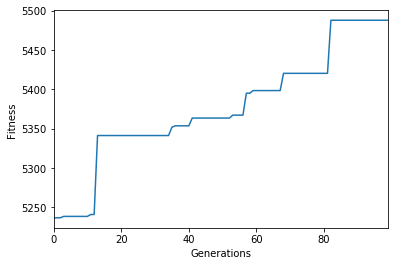

In [34]:
# and this graph shows the fitness increase over the generations
p = allpop_ranks.groupby('gen')['fitness'].max().plot()
p.set_ylabel('Fitness')
p.set_xlabel('Generations')
plt.show()

# looks like there is no plateau yet 

In [18]:
# saving best order and ga results
fname = f'results/nl_en_pop{pop_size}_elite{elite_size}' \
        f'_mutrate{mut_rate}_balancep{balance_penalty}_gens{generations}'
allpop_ranks.groupby('gen').head(1).to_csv(fname+'.csv', index=False)
pd.DataFrame(best_ind).to_hdf(fname+'.h5', key='data', index=False, header=None)

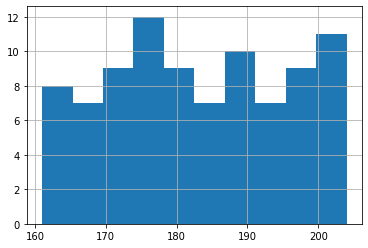

In [22]:
# the distribution of tasks per agents
tasks_per_agent = best_ind.sum(axis=1)
p = pd.Series(tasks_per_agent).hist()

# forcind the optimization on the balance really makes the distribution uniform, while trying to increase the quality

In [23]:
from genetic import quality_per_job

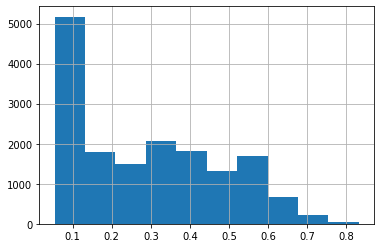

In [28]:
# however the quality per job shows that most tasks have very little quality
tasks_quality = quality_per_job(best_ind, nl_en_job_domain, nl_en_editor_domain_quality)
p = pd.Series(tasks_quality).hist()

Text(0.5, 1.0, 'avg quality per editor | skew:0.41 \n| kurtosis:-0.42')

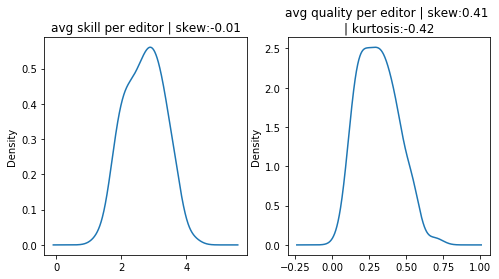

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
p1 = pd.Series(nl_en_editor_domain_skill.mean(axis=1)).plot.density(ax=ax[0])
ax[0].set_title(f'avg skill per editor | skew:{skew(nl_en_editor_domain_skill.mean(axis=1)):.2f}')
p1 = pd.Series(nl_en_editor_domain_quality.mean(axis=1)).plot.density(ax=ax[1])
ax[1].set_title(f'avg quality per editor | skew:{skew(nl_en_editor_domain_quality.mean(axis=1)):.2f}'\
               f' \n| kurtosis:{kurtosis(nl_en_editor_domain_quality.mean(axis=1)):.2f}')

# editor quality is quite left skewed

In [29]:
# matrix_shape = (89, 16290)
shape = (nl_en_editors.shape[0], nl_en_tasks.shape[0])

pop_size = 50
elite_size = 8
mut_rate = 0.01
balance_penalty = 1  # 1 = no balance constrain
generations = 100

# generate initial population
print('generating population')
# ini_pop = gen_pop_mp(pop_size, shape, pool)
ini_pop = gen_pop(pop_size, shape, 42)

# additional parameters
print('running ga')
pop_ranks2, best_ind2 = genetic_algorithm(ini_pop, elite_size, mut_rate, balance_penalty,
                                           generations, nl_en_job_domain, nl_en_editor_domain_quality)

generating population
running ga
    index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
36     36   4787.4         4787.4        0.015276      0.016393   0.193682  -0.311285    1
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0   4787.4         4787.4        0.015276      0.016393   0.193682  -0.311285    2
    index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
37     37  4797.293333    4797.293333         0.01679      0.016667  -0.195606  -0.504718    3
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  4797.293333    4797.293333         0.01679      0.016667  -0.195606  -0.504718    4
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  4797.293333    4797.293333         0.01679      0.016667  -0.195606  -0.504718    5
   index      fitness  total_quality  b

   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  4938.893333    4938.893333        0.003799      0.006536    0.30562   0.325714   45
    index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
19     19  4954.64        4954.64        0.002373      0.007042   0.516058    0.60748   46
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  4954.64        4954.64        0.002373      0.007042   0.516058    0.60748   47
    index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
32     32  4958.88        4958.88        0.002218      0.006897   0.527316   0.639058   48
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  4958.88        4958.88        0.002218      0.006897   0.527316   0.639058   49
   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt

   index      fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5039.646667    5039.646667        0.006191      0.006623   0.213147  -0.376218   89
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
9      9  5046.32        5046.32        0.006346      0.006494   0.204672  -0.457413   90
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5046.32        5046.32        0.006346      0.006494   0.204672  -0.457413   91
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5046.32        5046.32        0.006346      0.006494   0.204672  -0.457413   92
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0      0  5046.32        5046.32        0.006346      0.006494   0.204672  -0.457413   93
   index  fitness  total_quality  balance_factor  range_factor  dist_skew  dist_kurt  gen
0 

In [58]:
allpop_ranks2 = pd.concat(pop_ranks2)

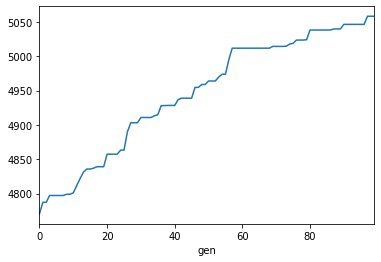

In [59]:
p = allpop_ranks2.groupby('gen')['fitness'].max().plot()

In [60]:
# save best order and ga results
fname = f'results/nl_en_pop{pop_size}_elite{elite_size}' \
        f'_mutrate{mut_rate}_balancep{balance_penalty}_gens{generations}'
allpop_ranks2.groupby('gen').head(1).to_csv(fname+'.csv', index=False)
pd.DataFrame(best_ind2).to_hdf(fname+'.h5', key='data', index=False, header=None)

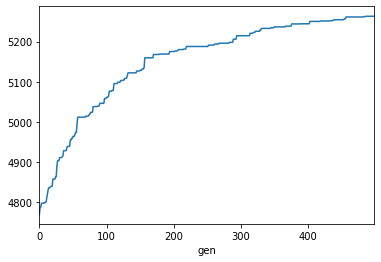

In [65]:
# I also did another with 500 gen
no_balance_500gen = pd.read_csv('results/nl_en_pop50_elite8_mutrate0.01_balancep1_gens500.csv')
p = no_balance_500gen.groupby('gen')['fitness'].max().plot()
# 500 gen is enough to start plateauing

In [67]:
no_balance_500gen.groupby('gen')['fitness'].max().max()

5263.3200000000015

In [76]:
# total quality reached 4765 with balance constrain (started at 4787.4, so it actually decreased)
# with no balance constrains and 500 generations, it reached 5263
f'{(5263.3/4787.4)-1:.1%} increase'

'9.9% increase'

In [78]:
no_balance_500gen_bestind = pd.read_hdf('results/nl_en_pop50_elite8_mutrate0.01_balancep1_gens500.h5',key='data')

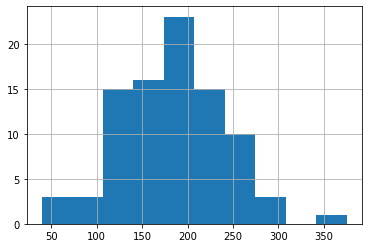

In [80]:
# task distribution on the optimized model without balanced distribution contrain
p = pd.Series(no_balance_500gen_bestind.sum(axis=1)).hist()
# it looks like a normal distribution

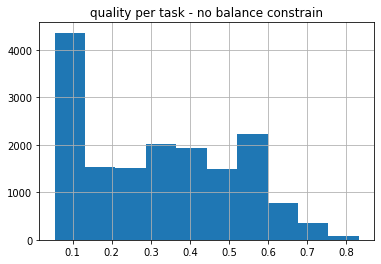

In [100]:
# looking at the quality per task distribution
tasks_quality3 = quality_per_job(no_balance_500gen_bestind, nl_en_job_domain, nl_en_editor_domain_quality)
p = pd.Series(tasks_quality3).hist()
plt.title('quality per task - no balance constrain')
plt.show()
# it seems like most of the increase came from a little increase at the front rather and a decrease at the low quality 
# assignments. A rather directed initial distribution, targeting higher quality in the initial state of the optimization
# may yield better results

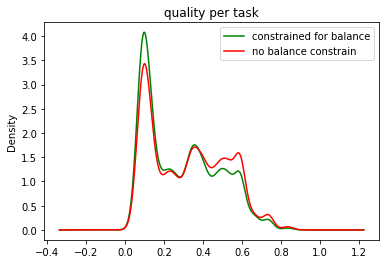

In [98]:
p = pd.Series(tasks_quality).plot.density(color='green',label='constrained for balance')
p = pd.Series(tasks_quality3).plot.density(color='red', label='no balance constrain')
plt.legend()
plt.title('quality per task')
plt.show()

### Room for improvement
- start with a better initial assignment approach instead of random
- find bottlenecks in the optimization and decrease them with cython
- grid search parameters for better results at the optimization
- consider price per task as well

In [5]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import pandas; print("Pandas", pandas.__version__)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
import matplotlib; print('matplotlib', matplotlib.__version__)

Windows-10-10.0.18362-SP0
Python 3.6.7 |Anaconda, Inc.| (default, Oct 28 2018, 19:44:12) [MSC v.1915 64 bit (AMD64)]
Pandas 0.25.2
NumPy 1.16.5
SciPy 1.3.1
Scikit-Learn 0.21.3
matplotlib 3.1.1
